# word2vec

  
## 추론 기반 기법과 신경망
- 단어를 벡터로 표현하는 방법 중 성공적인 기법을 크게 두 분류로 나눌 수 있다.
    - 통계 기반 기법
    - 추론 기반 기법
    
    

### 통계 기반 기법의 문제점
- 통계 기반 기법에서는 주변 단어의 빈도를 기초로 단어를 표현함.
    - 구체적으로는 단어의 동시발생 행렬을 만들고, 그 행렬에 SVD를 적용하여 밀집벡터(단어의 분산 표현)를 얻었다.
    - 대규모 말뭉치를 다룰 때 문제가 발생
    - SVD를 적용하는 비용은 $O(n^{3})$
- 통계 기반 기법은 학습 데이터를 한꺼번에 처리한다.(배치 학습)
- 추론 기반 기법은 학습 데이터의 일부를 사용하야여 순차적으로 학습한다.(미니 배치학습)
- 추론 기반 기법을 사용할 경우 GPU를 통한 병렬 계산도 가능해져서 학습 속도를 높일 수 있다.

### 추론 기반 기법 개요
- 추론이란 주변 단어(맥락)가 주어졌을 때 ? 에 무엇이 들어가는지를 추측하는 작업이다.
- 추론 기반 기법도 통계 기반 기법처럼 분초 가설에 기초한다. 
- 분포 가설 : **단어의 의미는 주변 단어에 의해 형성된다.** 라는 가설

### 신경망에서의 단어 처리
- 대표적으로 사용하는 방법 : One-Hot 
- 총 어휘 수 만큼의 원소를 갖는 벡터를 준비하고 인덱스가 단어 ID와 같은 원소를 1, 나머지는 모두 0으로 설정


In [1]:
# 완전 연결 계층에 의한 변환
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 입력
W = np.random.randn(7, 3)             # 가중치
h = np.matmul(c, W)                   # 중간 노드
print(h)

[[ 0.37793141  1.26688646 -1.78352323]]


In [2]:
from common.layers import MatMul

In [3]:
layer = MatMul(W)

In [4]:
h = layer.forward(c)
print(h)

[[ 0.37793141  1.26688646 -1.78352323]]


## 단순한 word2vec
여기서 사용할 신경망은 word2vec에서 제안하는 CBOW(Continuous bag-of-words)모델이다.

### CBOW 모델의 추론 처리
- CBOW 모델: 맥락으로부터 target을 추축하는 용도의 신경망
    - target : 중앙 단어
    - 맥락 : 그 주변 단어
- CBOW 입력 : 맥락("you", "goodbye"같은 단어들의 목록)
    - 이 맥락을 one-hot 표현으로 변환하여 CBOW 모델이 처리할 수 있도록 준비

In [5]:
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# weight init
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# Make layer
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# forward propagation
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[-4.66597811 -2.8664437  -0.67539428  2.04582813  0.7098195   0.70401302
  -1.87645244]]


## Word2vec 학습 데이터 준비

### 맥락과 타깃
- word2vec에서 이용하는 신경망의 input은 맥락이다.
- 그리고 정답 레이블은 타깃 즉 맥락에 둘러 싸인 중앙의 단어 이다.
- word2vec에서 해야할 일은 맥락을 입력했을 때 타깃이 출연하는 확률을 높이는 것이다.

In [6]:
from common.util import preprocess

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

[0 1 2 3 4 1 5 6]


In [7]:
print(id_to_word)

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [8]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t==0: continue
            cs.append(corpus[idx+t])
        contexts.append(cs)
    return np.array(contexts), np.array(target)

In [9]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [10]:
contexts

array([[0, 2],
       [1, 3],
       [2, 4],
       [3, 1],
       [4, 5],
       [1, 6]])

In [11]:
target

array([1, 2, 3, 4, 1, 5])

In [12]:
from common.util import create_contexts_target, convert_one_hot

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [13]:
target

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int32)

In [14]:
contexts

array([[[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]]], dtype=int32)

In [15]:
# simple cbow
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        W_in = 0.01 * np.random.randn(V,H).astype('f')
        W_out = 0.01 * np.random.randn(H,V).astype('f')
        
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:,0])
        h1 = self.in_layer1.forward(contexts[:,1])
        h = (h0 + h1) / 2
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout = 1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= .5
        self.in_layer0.backward(da)
        self.in_layer1.backward(da)

        return None
    

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

/Users/h/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/h/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/h/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/h/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/h/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/h/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:1

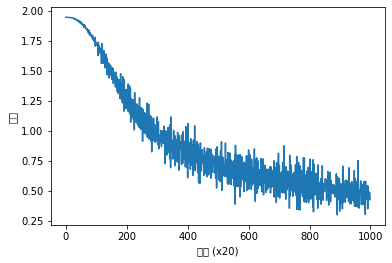

In [20]:
from common.trainer import Trainer
from common.optimizer import Adam

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)


model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [21]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-0.87337345  0.9595696   1.1270602  -1.6235621  -0.97802114]
say [ 1.2354931  -1.1932597  -0.29809415 -1.24707     0.8670654 ]
goodbye [-1.0380766   1.0311328   0.7048116  -0.00867517 -0.9959191 ]
and [ 1.007542   -0.980138    1.8372962  -0.58864564  1.5173447 ]
i [-1.035828    1.0281011   0.6923908   0.00735291 -1.0180959 ]
hello [-0.87112933  0.957037    1.1337205  -1.6251562  -0.9702341 ]
. [ 1.1068113 -1.0934424 -1.5074159 -1.3068539 -1.5112219]
